In [2]:
import glob
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.gridspec as gridspec
# import xesmf as xe
import datetime as dt
import matplotlib.pyplot as plt

import cartopy.feature as feat

folder = ['/projects/NS9252K/noresm/cases/WP4_shofer/n.n202.NSSP585frc2.f09_tn14.ssp585.001_global/atm/hist/COSP/cloud_feedbacks/',
          '/projects/NS9252K/noresm/cases/WP4_shofer/n.n202.NSSP585frc2.f09_tn14.ssp585.002_NH/atm/hist/COSP/cloud_feedbacks/',
          '/projects/NS9252K/noresm/cases/WP4_shofer/n.n202.NSSP585frc2.f09_tn14.ssp585.003_SH/atm/hist/COSP/cloud_feedbacks/',
          '/projects/NS9252K/noresm/cases/WP4_shofer/n.n202.NSSP585frc2.f09_tn14.ssp585.004_BASE_end/atm/hist/COSP/cloud_feedbacks/']


def weighted_mean(ds):
    # Create weights
    weights_n = np.cos(np.deg2rad(ds.lat))
    weighted = ds.weighted(weights_n)
    mean_arctic = weighted.mean(dim=['lat', 'lon'])

    return mean_arctic


def preprocess(ds):
    ds['year'] = pd.to_datetime(str(ds.year.values))
    return ds


def cld_feedback_df(ds_list, area=['Global', 'NH', 'SH', 'Control']):
    # Extract all the cloud feedbacks
    df_list = []
    for i in range(4):
        try:
            test = weighted_mean(ds_list[i]).mean(dim='month')
        except AttributeError:
            test = ds_list[i].mean(dim='month')
        df = test.isel(year=[-2, -1]).to_dataframe()
        df['year'] = df.index
        df['Area'] = area[i]
        # df.melt reshapes the dataframe for plotting with seaborn
        df_new = df.melt(id_vars=['year', 'Area'])

        df_list.append(df_new)
        all_dfs = pd.concat(df_list)

    return all_dfs


# Lists where 3x3 feedback outputs are stored: SW, LW and NET for all runs
list_SW = []
list_LW = []
list_net = []

names = ['Global', 'NH', 'SH', 'Control']
colors = ['black', '#1f78b4', '#b2df8a', 'orange']
i = 0
# fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
for f in folder:
    list_files_SW = sorted(glob.glob(f + 'SW_cloud_feedbacks_ALL*.nc'))
    list_files_LW = sorted(glob.glob(f + 'LW_cloud_feedbacks_ALL*.nc'))

    ds_SW = xr.open_mfdataset(
        list_files_SW, concat_dim='year', combine='nested', preprocess=preprocess)
    ds_LW = xr.open_mfdataset(
        list_files_LW, concat_dim='year', combine='nested', preprocess=preprocess)
    net = xr.open_dataset(f + 'NET_cloud_feedbacks_ALL_combined.nc')

    # weighted_mean(ds_SW.SWcld_tot).mean(dim=['month']
    #                                     ).isel(year=[-2,-1]).plot(label=names[i] + '_SW', linestyle='dotted', color=colors[i], ax=axs, marker='*')
    # weighted_mean(ds_LW.LWcld_tot).mean(dim=['month']
    #                                     ).isel(year=[-2,-1]).plot(label=names[i] + '_LW', linestyle='dashed', color=colors[i], ax=axs, marker='*')

    # # net = ds_SW.SWcld_tot.mean(
    # #     dim=['lat', 'lon', 'month']) + ds_LW.LWcld_tot.mean(dim=['lat', 'lon', 'month'])
    # weighted_mean(net['NETcld_tot']).mean(dim=['month']
    #                                       ).isel(year=[-2,-1]).plot(label=names[i] + '_Net',
    #                                                                  linestyle='solid', lw=3, color=colors[i], ax=axs, marker='*')

    list_SW.append(ds_SW)
    list_LW.append(ds_LW)
    list_net.append(net)

    # # extract all net feedbacks
    # new = xr.Dataset()
    # new['NETcld_tot'] = ds_SW.SWcld_tot + ds_LW.LWcld_tot
    # new['NETcld_amt'] = ds_SW.SWcld_amt + ds_LW.LWcld_amt
    # new['NETcld_alt'] = ds_SW.SWcld_alt + ds_LW.LWcld_alt
    # new['NETcld_tau'] = ds_SW.SWcld_tau + ds_LW.LWcld_tau
    # new['NETcld_err'] = ds_SW.SWcld_err + ds_LW.LWcld_err
    #
    # new.to_netcdf(f + 'NET_cloud_feedbacks_ALL_combined.nc')

    i += 1

# plt.legend()
# fig.tight_layout()
# sns.despine()
# fig.savefig(
#     '/projects/NS9252K/noresm/cases/WP4_shofer/Figures/cloud_feedbacks_ts.png')


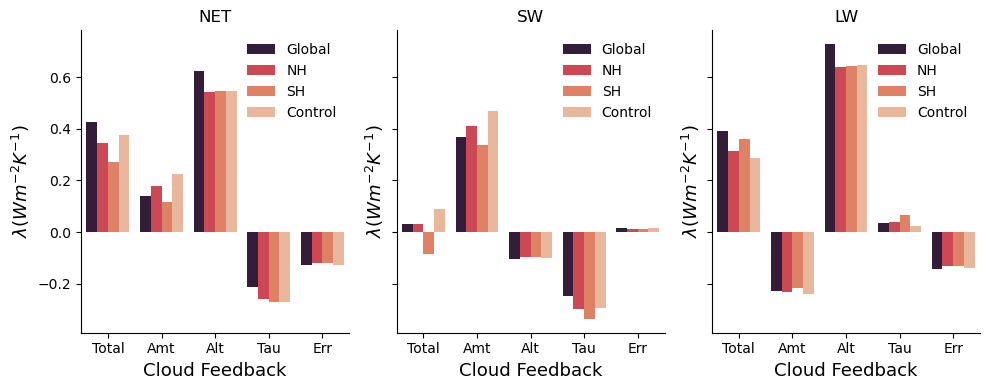

In [5]:
net_dfs = cld_feedback_df(list_net)
sw_dfs = cld_feedback_df(list_SW)
lw_dfs = cld_feedback_df(list_LW)
mask = (net_dfs.year == '2049')

# net_dfs = net_dfs.where((net_dfs['Area'] == 'Global') | (net_dfs['Area'] == 'CTRL'))
# sw_dfs = sw_dfs.where((sw_dfs['Area'] == 'Global') | (sw_dfs['Area'] == 'CTRL'))
# lw_dfs = lw_dfs.where((lw_dfs['Area'] == 'Global') | (lw_dfs['Area'] == 'CTRL'))

titles = ['NET', 'SW', 'LW']
ticks = ['Total', 'Amt', 'Alt', 'Tau', 'Err']
palette = [sns.color_palette("rocket")[0], sns.color_palette("rocket")[-3], 
           sns.color_palette("rocket")[-2], sns.color_palette("rocket")[-1]]
plt.close('all')
fig, axs = plt.subplots(nrows=1, ncols=3, sharey='row',
                        squeeze=True, figsize=(10, 4))

sns.barplot(x='variable', y='value', hue='Area',
            data=net_dfs, palette=palette, ax=axs[0], errorbar=None)
sns.barplot(x='variable', y='value', hue='Area',
            data=sw_dfs, palette=palette, ax=axs[1], errorbar=None)
sns.barplot(x='variable', y='value', hue='Area',
            data=lw_dfs, palette=palette, ax=axs[2], errorbar=None)

for i in range(3):
    axs[i].set_title(titles[i])
    axs[i].set_xticklabels(ticks)
    axs[i].legend(frameon=False)
    axs[i].set_ylabel(r'$\lambda (Wm^{-2}K^{-1})$', fontsize=13)
    axs[i].set_xlabel('Cloud Feedback', fontsize=13)

sns.despine()
fig.tight_layout()

fig.savefig(
    '/projects/NS9600K/shofer/repos/NorESM2/microphysics_analysis/Figures/cloud_feedbacks_bar_1x3_CTRLvsAll.png')
fig.savefig(
    '/projects/NS9600K/shofer/repos/NorESM2/microphysics_analysis/Figures/cloud_feedbacks_bar_1x3_CTRLvsAll.pdf', format='PDF')


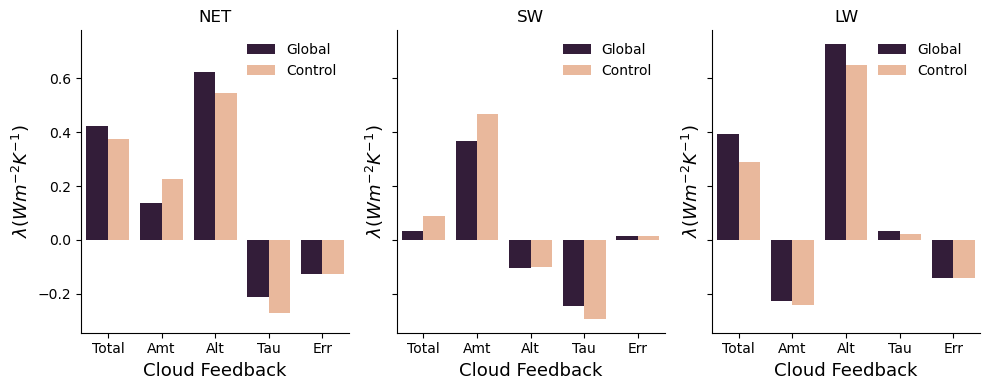

In [6]:
net_dfs = net_dfs.where((net_dfs['Area'] == 'Global') | (net_dfs['Area'] == 'Control'))
sw_dfs = sw_dfs.where((sw_dfs['Area'] == 'Global') | (sw_dfs['Area'] == 'Control'))
lw_dfs = lw_dfs.where((lw_dfs['Area'] == 'Global') | (lw_dfs['Area'] == 'Control'))

titles = ['NET', 'SW', 'LW']
ticks = ['Total', 'Amt', 'Alt', 'Tau', 'Err']
palette = [sns.color_palette("rocket")[0], sns.color_palette("rocket")[-1]]
plt.close('all')
fig, axs = plt.subplots(nrows=1, ncols=3, sharey='row',
                        squeeze=True, figsize=(10, 4))

sns.barplot(x='variable', y='value', hue='Area',
            data=net_dfs, palette=palette, ax=axs[0], errorbar=None)
sns.barplot(x='variable', y='value', hue='Area',
            data=sw_dfs, palette=palette, ax=axs[1], errorbar=None)
sns.barplot(x='variable', y='value', hue='Area',
            data=lw_dfs, palette=palette, ax=axs[2], errorbar=None)

for i in range(3):
    axs[i].set_title(titles[i])
    axs[i].set_xticklabels(ticks)
    axs[i].legend(frameon=False)
    axs[i].set_ylabel(r'$\lambda (Wm^{-2}K^{-1})$', fontsize=13)
    axs[i].set_xlabel('Cloud Feedback', fontsize=13)

sns.despine()
fig.tight_layout()

fig.savefig(
    '/projects/NS9600K/shofer/repos/NorESM2/microphysics_analysis/Figures/cloud_feedbacks_bar_1x3_CTRLvsGlobal_NETSWLW.png')
fig.savefig(
    '/projects/NS9600K/shofer/repos/NorESM2/microphysics_analysis/Figures/cloud_feedbacks_bar_1x3_CTRLvsGlobal_NETSWLW.pdf', format='PDF')

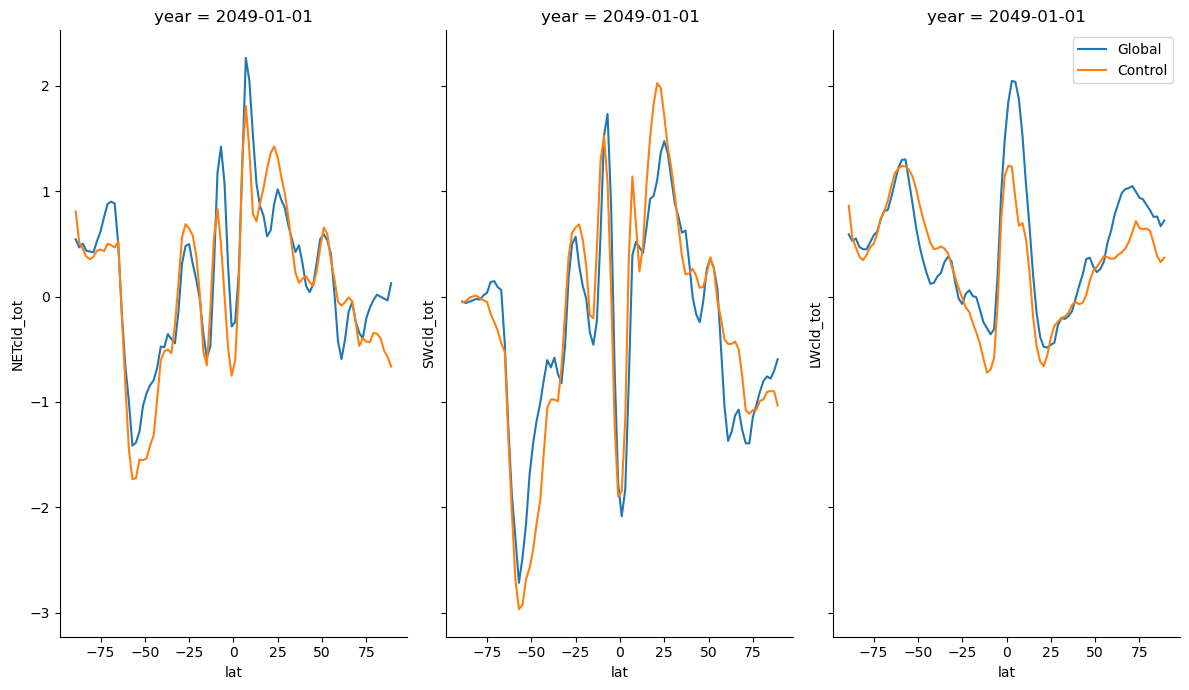

In [7]:
# =======================================================================================
# =============== LATITUDE CROSS SECTIONS ===============================================
# =======================================================================================
names = ['Global', 'Control']
vars = ['NETcld_tot', 'NET']

plt.close('all')
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=True,
                        sharey=True, figsize=(12, 7))
for i in [0,-1]:

    list_net[i]['NETcld_tot'].isel(
        year=-2).mean(dim=['lon', 'month']).plot(label=names[i], ax=axs[0])
    list_SW[i]['SWcld_tot'].isel(
        year=-2).mean(dim=['lon', 'month']).plot(label=names[i], ax=axs[1])
    list_LW[i]['LWcld_tot'].isel(
        year=-2).mean(dim=['lon', 'month']).plot(label=names[i], ax=axs[2])

sns.despine()
plt.legend()
fig.tight_layout()

fig.savefig(
    '/projects/NS9600K/shofer/repos/NorESM2/microphysics_analysis/Figures/cloud_feedbacks_bar_1x3_CTRLvsGlobal_cross.png')
fig.savefig(
    '/projects/NS9600K/shofer/repos/NorESM2/microphysics_analysis/Figures/cloud_feedbacks_bar_1x3_CTRLvsGlobal_cross.pdf', format='PDF')

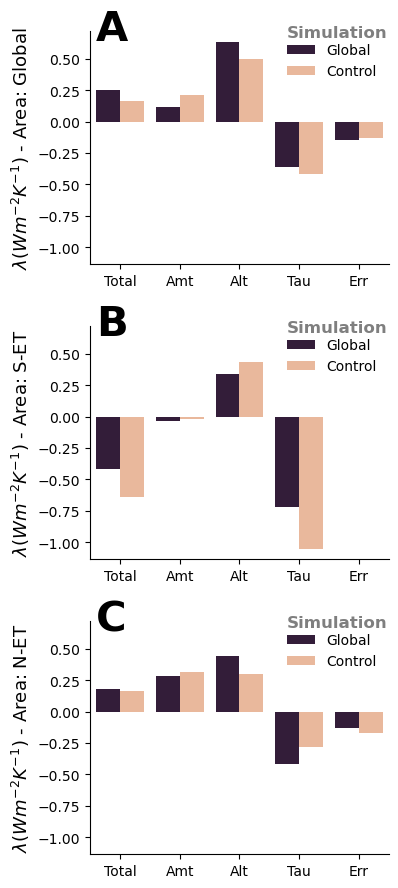

In [12]:
names = ['Global', 'NH', 'SH', 'Control']
list_net_2049 = [weighted_mean(list_net[i].sel(year='2049')).mean(dim='month') for i in range(len(list_net))]
list_net_2049_SH = [weighted_mean(list_net[i].sel(year='2049',lat=slice(-90,-30))).mean(dim='month')
                    for i in range(len(list_net))]

list_net_2049_NH = [weighted_mean(list_net[i].sel(year='2049',lat=slice(30,90))).mean(dim='month')
                    for i in range(len(list_net))]



def cld_feedback_df(ds_list, area=['Global', 'NH', 'SH', 'Control']):
    # Extract all the cloud feedbacks
    df_list = []
    for i in range(4):
        test = ds_list[i]
        df = test.to_dataframe()
        df['year'] = df.index
        df['Area'] = area[i]
        # df.melt reshapes the dataframe for plotting with seaborn
        df_new = df.melt(id_vars=['year', 'Area'])

        df_list.append(df_new)
        all_dfs = pd.concat(df_list)

    return all_dfs

# Global feedbacks for 4 simulations in 2049
all_2049 = cld_feedback_df(list_net_2049)
# NH feedbacks for 4 simulations locally in 2049
all_2049_NH = cld_feedback_df(list_net_2049_NH)
# SH feedbacks for 4 simulations locally in 2049
all_2049_SH = cld_feedback_df(list_net_2049_SH)

dict_final = {}
dict_final['Global'] = all_2049
dict_final['NH'] = all_2049_NH
dict_final['SH'] = all_2049_SH

# print(dict_final['Global'].loc[dict_final['Global']['Area'].isin(['Global','CTRL'])])
# First axis is NorESM2 Global vs Control; Region: Globally
# The 
df_one = dict_final['Global'].loc[dict_final['Global']['Area'].isin(['Global','Control'])]
# Second axis is NorESM2 SH vs Control; Region: SH
df_two = dict_final['SH'].loc[dict_final['SH']['Area'].isin(['Global','Control'])]
# Third axis in NorESM2 NH vs Control; Region: NH
df_three = dict_final['NH'].loc[dict_final['NH']['Area'].isin(['Global','Control'])]

list_dfs = [df_one, df_two, df_three]


# ===============================================
# ====== PLOTTING ROUTINE =======================
# ===============================================
# Plot 1x3 Bar plots
# ==========================
labels = ['A', 'B', 'C']
palette = [sns.color_palette("rocket")[0], sns.color_palette("rocket")[-1]]
ticks = ['Total', 'Amt', 'Alt', 'Tau', 'Err']
legend_add = [' - Area: Global', ' - Area: S-ET', ' - Area: N-ET']

plt.close('all')
fig, axs = plt.subplots(nrows=3, ncols=1, sharey='all',
                        squeeze=True, figsize=(4, 9))
i = 0
for data in list_dfs:
    sns.barplot(x='variable', y='value', hue='Area',
                data=data, palette=palette, ax=axs[i], errorbar=None)
    axs[i].set_xticklabels(ticks)
    axs[i].get_legend().remove()
    axs[i].legend(frameon=False, loc='upper right')
    axs[i].set_ylabel(r'$\lambda (Wm^{-2}K^{-1})$' + legend_add[i], fontsize=13)
    # axs[i][j].set_xlabel('Cloud Feedback', fontsize=13)
    axs[i].set_xlabel('')
    axs[i].text(2.79, 0.67, 'Simulation', fontsize=12, weight='bold', alpha=0.5)
    axs[i].text(-0.4, 0.65, labels[i], fontsize=30, weight='bold')
    
    sns.despine(ax=axs[i])
    i += 1

fig.tight_layout()

fig.savefig(
    '/projects/NS9600K/shofer/repos/NorESM2/microphysics_analysis/Figures/cloud_feedbacks_bar_1x3_CTRLvsGlobal.png')
fig.savefig(
    '/projects/NS9600K/shofer/repos/NorESM2/microphysics_analysis/Figures/cloud_feedbacks_bar_1x3_CTRLvsGlobal.pdf', format='PDF')

In [ ]:
# Plot only net 1x3 bar plots
# ============================
names_list = ['Global', 'NH', 'SH', 'Ctrl']
titles = ['NET']
ticks = ['Total', 'Amt', 'Alt', 'Tau', 'Err']
palette = [sns.color_palette("rocket")[0], sns.color_palette(
    "rocket")[-3], sns.color_palette("rocket")[-1]]


# Plot 1x3 Bar plots
# ==========================
labels = ['A', 'B', 'C']
plt.close('all')
fig, axs = plt.subplots(nrows=3, ncols=1, sharey='all',
                        squeeze=True, figsize=(4, 9))

axs[0].set_title(titles[0], fontsize=22)
i = 0
for name in names_list:

    sns.barplot(x='variable', y='value', hue='Area',
                data=dict_all[name][0], palette=palette, ax=axs[i], ci=None)

    axs[i].set_xticklabels(ticks)
    axs[i].get_legend().remove()
    axs[i].legend(frameon=False, loc='upper right')
    axs[i].set_ylabel(r'$\lambda (Wm^{-2}K^{-1})$', fontsize=13)
    # axs[i][j].set_xlabel('Cloud Feedback', fontsize=13)
    axs[i].set_xlabel('')
    axs[i].text(-0.4, 0.65, labels[i], fontsize=30, weight='bold')
    axs[i].text(0.2, 0.05, names_list[i], fontsize=30,
                transform=axs[i].transAxes, alpha=0.6)
    i += 1


sns.despine()
fig.tight_layout()

fig.savefig(
    '/projects/NS9252K/noresm/cases/WP4_shofer/Figures/cloud_feedbacks_bar_1x3.png')
fig.savefig(
    '/projects/NS9252K/noresm/cases/WP4_shofer/Figures/cloud_feedbacks_bar_1x3.pdf', format='PDF')